# Dynamic Threshold Algorithm 4.0

### Details：
1. Do some refactoring  
2. Mutli-metrics  
3. Predict trend

In [1]:
# -*- coding:utf-8 -*-
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import random
import datatools as dt

In [2]:
reload(dt)

<module 'datatools' from 'datatools.pyc'>

## 1. Load data

In [3]:
raw = dt.load_csv('../data/dongguan.csv')
raw.columns = ['SHOUYE', 'FINANCE', 'TRADE']

In [4]:
# define holiday list
guoqing = dt.to_date_list(pd.date_range(start='2017-10-01', end='2017-10-08', freq='D'))
guoqing

['2017-10-01',
 '2017-10-02',
 '2017-10-03',
 '2017-10-04',
 '2017-10-05',
 '2017-10-06',
 '2017-10-07',
 '2017-10-08']

In [6]:
filtered_data = dt.preprocess(raw, holiday_list=guoqing, max_nan=0.01)
dt.check_data(filtered_data)

Date Range: [2017-06-12] ~ [2017-12-06]
Columns: ['SHOUYE', 'FINANCE', 'TRADE']
Points Per Day: 1440
Missing Data: 0/116(0.00%)
Nan Percentage: 0.00%


In [7]:
filtered_data = filtered_data.loc['2017-10-09':]

In [8]:
SY, FN, TR = filtered_data['SHOUYE'], filtered_data['FINANCE'], filtered_data['TRADE']

## 2. Choose good days By Outlier Detection methods

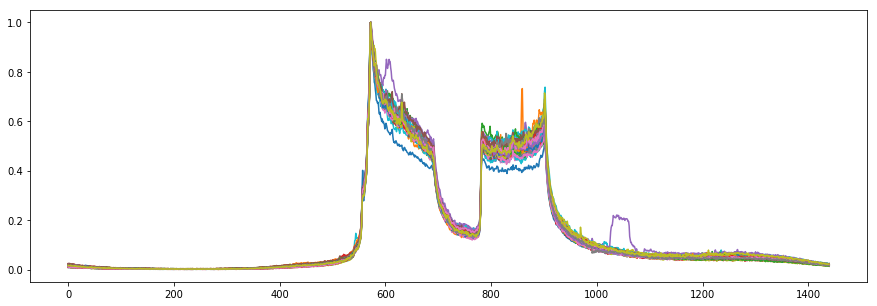

In [9]:
data_nd = SY.values.copy()
data_nd_re = data_nd.reshape((-1, 1440))
data_nd_re_norm = dt.normalize_max(data_nd_re)
plt.figure(figsize=(15, 5))
plt.plot(data_nd_re_norm.T)
plt.show()

In [10]:
wash(data_nd, method='lof').shape

NameError: name 'wash' is not defined

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

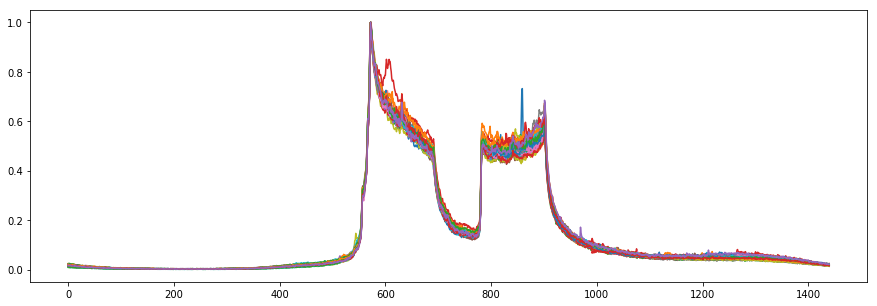

In [9]:
clf1 = IsolationForest()
clf1.fit(data_nd_re_norm)
labels1 = clf1.predict(data_nd_re_norm)
plt.figure(figsize=(15, 5))
plt.plot(data_nd_re_norm[np.where(labels1==1)].T)
plt.show()

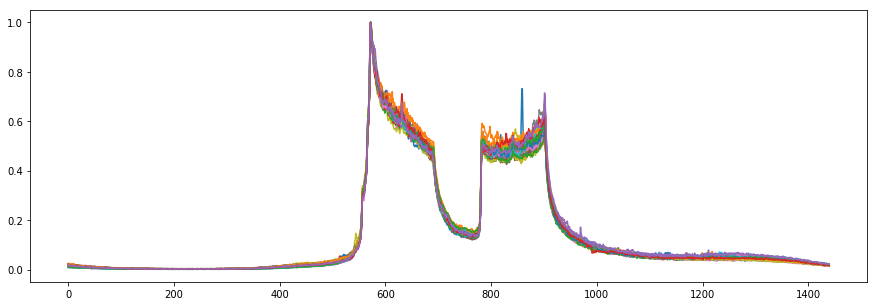

In [10]:
clf2 = LocalOutlierFactor()
labels2 = clf2.fit_predict(data_nd_re_norm)
plt.figure(figsize=(15, 5))
plt.plot(data_nd_re_norm[np.where(labels2==1)].T)
plt.show()

In [ ]:
# discard
# clf3 = EllipticEnvelope()
# clf3.fit(data_nd_re_norm)
# labels3 = clf3.predict(data_nd_re_norm)
# plt.figure(figsize=(15, 5))
# plt.plot(data_nd_re_norm[np.where(labels3==1)].T)
# plt.show()

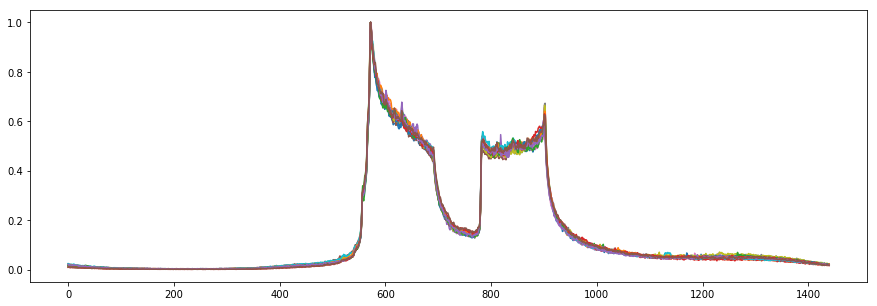

In [235]:
clf4 = svm.OneClassSVM()
clf4.fit(data_nd_re_norm)
labels4 = clf4.predict(data_nd_re_norm)
plt.figure(figsize=(15, 5))
plt.plot(data_nd_re_norm[np.where(labels4==1)].T)
plt.show()

In [236]:
plt.figure(figsize=(15, 5))
plt.plot(data_nd_re_norm[np.where(labels4==-1)].T)
plt.show()

In [462]:
np.where(labels4==-1)[0].shape

(23L,)

In [611]:
good_data = data_nd_re[np.where(labels4==1)]
bad_data = data_nd_re[np.where(labels4==-1)]

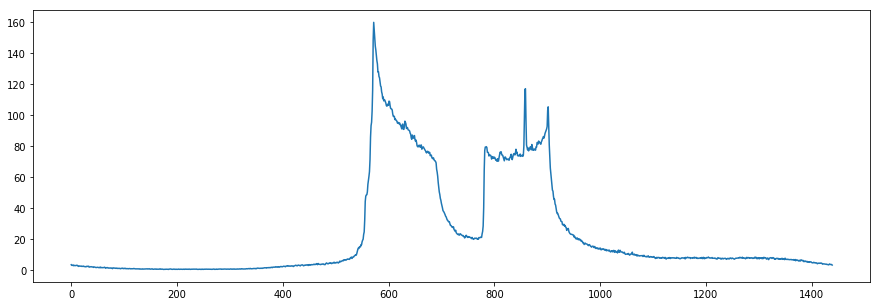

In [613]:
plt.figure(figsize=(15, 5))
plt.plot(bad_data[1].T)
plt.show()

In [461]:
good_data.shape

(16L, 1440L)

**Conclusion**  
Choose *One class svm* method first!

## 3. Trend Seasonal Residual Decompose

In [244]:
plt.figure(figsize=(15, 7))
plt.plot(good_data.ravel())
plt.show()

In [245]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(good_data.ravel(), model='additive', freq=1440)

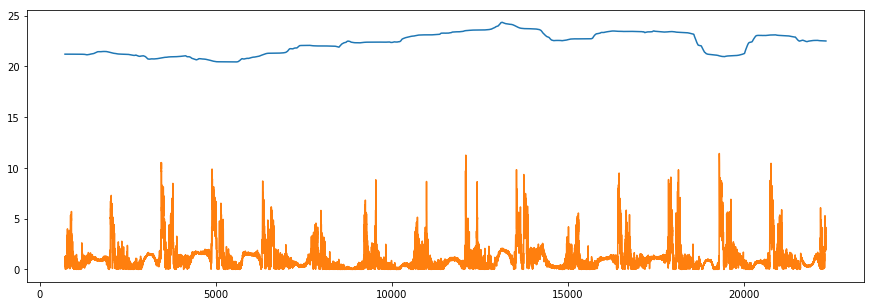

In [1578]:
plt.figure(figsize=(15, 5))
plt.plot(result.trend)
# plt.plot(result.seasonal[-1440:][:, np.newaxis])
n = 10
# plt.plot(result.resid[-1440*(n):-1440*(n-1)])
plt.plot(np.abs(result.resid))
# plt.plot(good_data.ravel())
plt.show()

In [363]:
mu, std = noise_model(np.absolute(result.resid))

In [1616]:
%%time
noise_test = np.random.normal(mu, std)

plt.figure(figsize=(15, 8))
# plt.plot(mu)
# plt.plot(std)
plt.plot(gen_noise((mu, std), random_state=41))
plt.show()

Wall time: 212 ms


In [1626]:
ret = tsr_decompose(good_data)

In [582]:
ret.trend

array([[21.21300281, 21.21368413, 21.21458982, ..., 21.02640539,
        21.02729357, 21.0278137 ],
       [21.02830289, 21.02913934, 21.02971862, ..., 20.81084798,
        20.80911824, 20.80757326],
       [20.80650466, 20.80509574, 20.80387092, ..., 20.76454378,
        20.76279212, 20.76181385],
       ...,
       [23.41123752, 23.41106106, 23.41113493, ..., 22.07712833,
        22.07606703, 22.07553622],
       [22.07485893, 22.07409565, 22.07328329, ..., 22.37741358,
        22.37820621, 22.37878485],
       [22.37991496, 22.38105384, 22.38152726, ..., 22.52777691,
        22.52988726, 22.53197707]])

In [583]:
ret.seasonal

array([-19.44285549, -19.54820858, -19.56821925, ..., -19.17461001,
       -19.19001355, -19.18343858])

In [584]:
ret.residual

(array([0.77959354, 0.7608863 , 0.71669438, ..., 0.68670709, 0.63590247,
        0.64568054]),
 array([0.43960636, 0.44368727, 0.4310594 , ..., 0.40510103, 0.42800954,
        0.43269729]))

In [1479]:
plt.figure(figsize=(15, 8))
# plt.plot(ret.seasonal+ret.trend[0])
plt.plot(ret.trend[:, 1])
plt.show()

In [1826]:
# test save model
import pickle
import os
import datetime

directory = 'models'
name = 'Linux cpu'
inpath = os.path.join(directory, name)
if not os.path.isdir(inpath):
    os.makedirs(inpath)
files = os.listdir(inpath)
print(files)
if len(files) > 5:
    os.remove(os.path.join(inpath, min(files)))
fullpath = os.path.join(directory, name, str(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))+'.pkl')
with open(fullpath, 'a+') as f:
    pickle.dump(ret, f)


['20180117_165748.pkl', '20180117_165749.pkl', '20180117_165750.pkl', '20180117_165753.pkl', '20180117_165756.pkl', '20180117_165758.pkl']


In [1690]:
# test restore model
directory = "Linux cpu"
if not os.path.isdir(directory):
    raise Exception('No such directory!')
files = os.listdir(directory)
fullpath = os.path.join(path, max(files))
with open(fullpath) as f:
    ret1 = pickle.load(f)

tsr(trend=array([[21.21300281, 21.21368413, 21.21458982, ..., 21.02640539,
        21.02729357, 21.0278137 ],
       [21.02830289, 21.02913934, 21.02971862, ..., 20.81084798,
        20.80911824, 20.80757326],
       [20.80650466, 20.80509574, 20.80387092, ..., 20.76454378,
        20.76279212, 20.76181385],
       ...,
       [23.41123752, 23.41106106, 23.41113493, ..., 22.07712833,
        22.07606703, 22.07553622],
       [22.07485893, 22.07409565, 22.07328329, ..., 22.37741358,
        22.37820621, 22.37878485],
       [22.37991496, 22.38105384, 22.38152726, ..., 22.52777691,
        22.52988726, 22.53197707]]), seasonal=array([-19.44285549, -19.54820858, -19.56821925, ..., -19.17461001,
       -19.19001355, -19.18343858]), residual=(array([0.77959354, 0.7608863 , 0.71669438, ..., 0.68670709, 0.63590247,
       0.64568054]), array([0.43960636, 0.44368727, 0.4310594 , ..., 0.40510103, 0.42800954,
       0.43269729])))

In [1480]:
good_data_norm = dt.normalize_max(good_data, return_norm=True)

train_data = good_data_norm[1]
regr = svm.SVR(kernel='rbf')
x = np.linspace(0, train_data.size-1, train_data.size)[:, np.newaxis]
regr.fit(x, train_data)
x_ = np.linspace(0, train_data.size, train_data.size+1)[:, np.newaxis]
y_ = regr.predict(x_)

plt.figure(figsize=(15, 7))
plt.plot(x, train_data)
plt.plot(x_, y_)
plt.plot(5, y_[-1], 'rD')
plt.text(4.5, y_[-1]+1, y_[-1], bbox=dict(facecolor='red', alpha=0.5))
plt.title("Predict the next day 'trend'")
plt.show()

## 4. Calculate baseline and threshold 

In [990]:
from PyAstronomy.pyasl import generalizedESD, pointDistGESD

In [1218]:
def adjust_up(x, k):
    return (1 + k*x/x.max())*x

def adjust_low(x, k):
    return (1 - k*x/x.max())*x

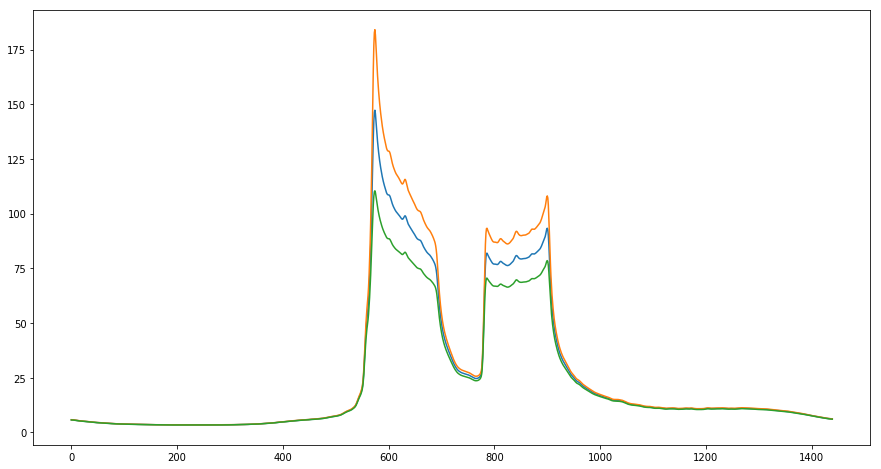

In [1222]:
plt.figure(figsize=(15, 8))
plt.plot(upper_thresh)
plt.plot(adjust_up(upper_thresh, 0.25))
plt.plot(adjust_low(upper_thresh, 0.25))
plt.show()

In [1747]:
bad_data

array([[1.65558749, 1.57770626, 1.79935626, ..., 3.37386248, 3.01785626,
        3.43760625],
       [3.46831249, 3.04299377, 3.106975  , ..., 3.63388748, 3.61739373,
        3.25926252],
       [3.45218125, 3.25141875, 3.33740625, ..., 3.08226879, 3.11789997,
        3.10245   ],
       ...,
       [3.15540622, 2.96665625, 2.923575  , ..., 2.59908754, 2.54029377,
        2.50221251],
       [2.68348125, 2.66275004, 2.60875002, ..., 3.09902498, 2.97418746,
        2.46846253],
       [2.7926625 , 2.56307498, 2.60184997, ..., 3.38832504, 3.45443749,
        3.6004625 ]])

In [1836]:
# define ku, kl (between 0 and 1)
ku = 0.1
kl = 0.1
# define minimum threshpld
min_thresh = np.max(ret.seasonal) / 20
# predict baseline
baseline = predict_baseline(ret, sm=5)
# calculate basic threshold
# upper_thresh = dt.smooth_moving(ret.trend.max(axis=0) + ret.seasonal + min_thresh, window_len=5)
# lower_thresh = dt.smooth_moving(np.maximum(ret.trend.min(axis=0) + ret.seasonal - min_thresh, 0), window_len=5)

# # adjust k
# upper_thresh = adjust_up(upper_thresh, ku)
# lower_thresh = adjust_low(lower_thresh, kl)
# # generate noise
# upper_noise = gen_noise(ret.residual, random_state=np.random.randint(100))
# lower_noise = gen_noise(ret.residual, random_state=np.random.randint(100))

# # add noise
# upper_thresh_wn = upper_thresh + np.maximum(upper_noise, 0)
# lower_thresh_wn = np.maximum(lower_thresh - np.maximum(lower_noise, 0), 0)

lower_thresh_wn, upper_thresh_wn = calc_dynamic_thresh(min_thresh, ret, k=K(kl, ku, 0), sm=5)

# real data test
# test_data = bad_data[1]
# test_data = good_data[0]
# test_data = bad_data[np.random.choice(len(bad_data))]
test_data = good_data[np.random.choice(len(good_data))]

# cut test_data
test_data = test_data[:1440]

# find anomalies
anomaly_idx0 = np.where(np.any([test_data > upper_thresh_wn[:test_data.size],
                               test_data < lower_thresh_wn[:test_data.size]], axis=0))[0]

# anomaly_idx0 = np.where(np.any([test_data > upper_thresh,
#                                test_data < lower_thresh], axis=0))

anomaly_idx1 = np.array(generalizedESD(test_data-baseline[:test_data.size], maxOLs=np.maximum(anomaly_idx1.size, 1))[1])
# anomaly_idx3 = np.array(pointDistGESD(test_data - baseline, maxOLs=anomaly_idx1.size)[1]) 

anomaly_idx = reduce(np.intersect1d, (anomaly_idx0, anomaly_idx1))
print(anomaly_idx0)

# anomaly pool
anomaly_pool = np.zeros((test_data.size, 1))
anomaly_pool[anomaly_idx0] += 1
anomaly_pool[anomaly_idx1] += 0.1

# visualization
t = np.linspace(0, 1440, 1440)
plt.figure(figsize=(15, 8))
# plt.plot(ret.seasonal+ret.trend[0])
# plt.plot(upper_thresh)
# plt.plot(lower_thresh)
# plt.fill_between(t, lower_thresh, upper_thresh, color=[.5, .5, .5], alpha=.5, label='Dynamic Threshold')
# plt.plot(baseline, 'g')
plt.fill_between(t, lower_thresh_wn, upper_thresh_wn, color=[.5, .5, .5], alpha=.5, label='Dynamic Threshold')
plt.plot(test_data, 'g')
plt.plot(anomaly_idx1, test_data[anomaly_idx1], 'mD', label='generalizedESD')
plt.plot(anomaly_idx0, test_data[anomaly_idx0], 'rD', label='anomaly')
plt.plot(test_data - baseline[:test_data.size], label='Residual')
plt.title('Dynamic Threshold Algorithm 4.0 Demo')
plt.legend()
# plt.savefig('Dynamic Threshold Algorithm 4.0 Demo.png', dpi=300)?
plt.show()

[554 555 564 565 569 779 780]


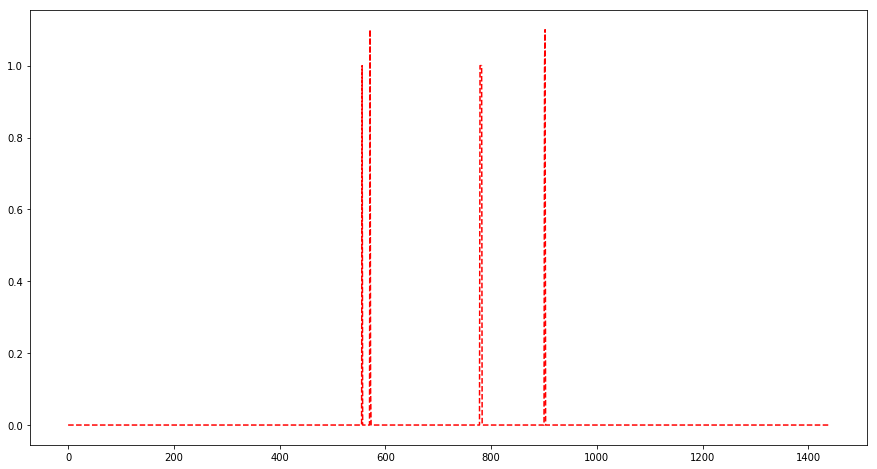

In [1771]:
plt.figure(figsize=(15, 8))
plt.plot(anomaly_pool, 'r--')
plt.show()

## 5. Dtaclass

In [11]:
from PyAstronomy.pyasl import generalizedESD
from collections import namedtuple
import pickle
from datetime import datetime

In [12]:
Lines = namedtuple('Lines', ['baseline', 'lower_thresh', 'upper_thresh'])
K = namedtuple('K', ['kl', 'ku', 'kn'])
tsr = namedtuple('tsr', ['trend', 'seasonal', 'residual'])

In [17]:
class DTA(object):
    __version__ = '4.0'

    counter = 0
    
    def __init__(self, series=None, name=None):
        self._model = None
        self._k = K(0.1, 0.1, 0)
        self._sm = 5

        if series:
            self._model = self.build_model(series)

        if name:
            self._name = name
        else:
            self._name = DTA.counter
            DTA.counter += 1
    
    def __repr__(self):
        return 'DTA<{0}：{1}>'.format(DTA.count, rself._name)
    
    def setk(self, k):
        self._k = K(k[0], k[1], k[2])
    
    def setsm(self, sm):
        self._sm = sm
    
    def check_model(self):
        if self._model is None:
            raise Exception("Model is empty! You must build model first.")

    def build_model(self, series, holiday_list=None):
        """Extract trend, seasonal and residual information from historical series."""
        # filter data, max_nan = 0.01
        try:
            data = dt.preprocess(series, holiday_list=holiday_list, max_nan=0.01)
            # choose normal-day data
            data_nd = wash(data.values)
            if data_nd.shape[0] < 5:
                raise Exception('Please provide more days of data!')
            # preform tsr_decompose
            self._model = tsr_decompose(data_nd)
        except:
            raise Exception('Data with TOO MANY NaNs!')

    def calculate(self):
        # step 1: check model
        self.check_model()
        # step 2: initialize basic parameters
        min_thresh = np.max(self._model.seasonal) / 50
        # step 3: predict baseline
        baseline = predict_baseline(self._model)
        # step 4: calculate dynamic threshold
        lower_thresh, upper_thresh = calc_dynamic_thresh(min_thresh, self._model, self._k, self._sm)
        # step 5: package the lines, save to self.lines and return
        self._lines = Lines(baseline, lower_thresh, upper_thresh)
    
    def detect(self, test_data):
        # step 1: check model
        self.check_model()
        end = test_data.size
        # anomaly breakthrough the dynamic threshold
        anomaly_idx0 = np.where(np.any([test_data < self._lines.lower_thresh[:end],
                               test_data > self._lines.upper_thresh[:end]], axis=0))[0]
        
        # anomaly detected by generalized ESD
        anomaly_idx1 = generalizedESD(test_data - self._lines.baseline, maxOLs=np.maximum(anomaly_idx0.size, 1))[1]
        # maybe add more anomaly detectors which return anomaly index of numpy.ndarray format
        # anomaly_idx2
        # ... ...
        # anomaly_idxn
        
        # generate anomaly_pool
        anomaly_pool = np.zeros((test_data.size, 1))
        anomaly_pool[anomaly_idx0] += 1
        # for i in range(n):
        #     anomaly_pool[anomaly_idxi] += 1
        # anomaly_pool /= n
        anomaly_pool[anomaly_idx1] += 0.1
        return anomaly_pool
        
    def update_model(self, series=None):
        self._model = self.build_model(series)
    
    def save(self, directory='.'):
        try:
            path = os.path.join(directory, self._name)
            if not os.path.isdir(path):
                os.makedirs(path)
            if len(files) > 5:
                os.remove(os.path.join(path, min(files)))
            fullpath = os.path.join(directory, self._name, str(datetime.now().strftime('%Y%m%d_%H%M%S'))+'.pkl')
            with open(fullpath, 'a+') as f:
                pickle.dump(self._model, f)
        except:
            raise Exception('Failed to save model: {!r}!'.format(self._name))
    
    def restore(self, directory='.'):
        try:
            path = os.path.join(directory, self._name)
            if not os.path.isdir(path):
                raise Exception('No such directory!')
            files = os.listdir(path)
            fullpath = os.path.join(path, max(files))
            with open(fullpath) as f:
                self._model = pickle.load(f)
        except:
            raise Exception('Failed to restore model: {!r}!')
    
    def adjust_lines(self, method='auto'):
        pass

In [1828]:
# smooth method 
def smooth(x,window_len=5,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len < 3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s = numpy.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = numpy.ones(window_len,'d')
    else:
        w = eval('numpy.'+window+'(window_len)')

    y = numpy.convolve(w/w.sum(), s, mode='valid')
    return y[(window_len//2-1):-(window_len//2)]


In [ ]:
# find anomaly
def generalizedESD(x):
    pass

def iForest(x):
    pass

def LOF(x):
    pass

In [1837]:
# wash data first
def wash(data, method='ocs'):
    '''Method: ocs, ifrt, lof'''
    data_re = data.reshape((-1, 1440))
    data_re_norm,_ = dt.normalize_max(data_re,return_norm=True)
    if method == 'lof':
        clf = LocalOutlierFactor()
        labels = clf.fit_predict(data_re_norm)
    elif method in ['ocs', 'ifrt']:
        if method == 'ocs':
            clf = svm.OneClassSVM(kernel='rbf').fit(data_re_norm)
        else:
            clf = IsolationForest().fit(data_re_norm)
        labels = clf.predict(data_re_norm)
    else:
        raise Exception("Wrong method: {!r}. Choose from ['ocs', 'ifrt', 'lof']".format(method))
    return data_re[np.where(labels==1)]
    
# decompose base_data:
def tsr_decompose(data):
    result = seasonal_decompose(data.ravel(), model='additive', freq=1440)
    data_trse = (result.trend+result.seasonal).reshape((-1, 1440))
    trend = result.trend.reshape((-1, 1440))[1:-1]
    seasonal = result.seasonal[-1440:]
    residual = noise_model(result.resid)
    return tsr(trend, seasonal, residual)


In [1419]:
# predic baseline
def predict_baseline(model, sm=1):
    trend, seasonal, _ = model
    n = trend.shape[0]
    x = np.linspace(0, n - 1, n)[:, np.newaxis]
    clf = svm.SVR().fit(x, trend.mean(axis=1))
    y = clf.predict(n)
    if sm:
        baseline = dt.smooth_moving(y + seasonal, window_len=sm)
    else:
        baseline = y + seasonal
    return baseline

In [1403]:
# build noise model
def noise_model(noise):
    noise_re = np.abs(noise.reshape((-1, 1440)))
    # build gussian model
    mu, std = np.nanmean(noise_re, axis=0), np.nanstd(noise_re, axis=0)
    return mu, std

def gen_noise(mu_std, random_state=None):
    mu, std = mu_std
    np.random.seed(random_state)
    return np.random.normal(mu, std)


In [1424]:
# calculate dynamic thresh
def calc_dynamic_thresh(min_thresh, model, k=K(0, 0, 0), sm=1):
    kl, ku, kn = k
    # random generate noise
    lower_noise = gen_noise(ret.residual, random_state=np.random.randint(100))
    upper_noise = gen_noise(ret.residual, random_state=np.random.randint(100))
    # basic threshold
    lower_thresh_base = dt.smooth_moving(model.trend.max(axis=0) + model.seasonal - min_thresh, window_len=sm)
    upper_thresh_base = dt.smooth_moving(model.trend.min(axis=0) + model.seasonal + min_thresh, window_len=sm)
    # adjust threshold and add noise
    lower_thresh = adjust_low(lower_thresh_base, kl) - kn * np.maximum(lower_noise, 0)
    upper_thresh = adjust_up(upper_thresh_base, ku) + kn * np.maximum(upper_noise, 0)
    # lower_thresh must be >= 0
    lower_thresh = np.maximum(lower_thresh, 0)
    return lower_thresh, upper_thresh